In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import os
import io
import logging
import ast
import warnings
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pydot
import graphviz

import tensorflow as tf
from tensorflow import keras

#warnings.filterwarnings(action='ignore', module='keras', message='^internal gelsd')

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, accuracy_score, multilabel_confusion_matrix, plot_confusion_matrix

from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.model_selection import iterative_train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Embedding, Conv1D, MaxPooling1D, Flatten, GlobalMaxPool1D, Dropout, SpatialDropout1D, GlobalAveragePooling1D, LSTM, Bidirectional
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.utils import plot_model
from keras import backend as K
import kerastuner as kt
from tqdm import tqdm

from transformers import DistilBertTokenizer, DistilBertConfig, TFDistilBertModel, BertTokenizer

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
print("Tensorflow version: ", tf.__version__)
print("Keras version: ", keras.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Tensorflow version:  2.4.1
Keras version:  2.4.0
Eager mode:  True
GPU is NOT AVAILABLE


In [4]:
datasets = "/datasets/"
path_datasets = "..{0}".format(datasets)

PATH_MODEL = "../model/"
PATH_BEST_MODELS = "../model/best_models/"

PATH_CORPUS = "../corpus/"
PATH_TOKENIZER = "../tokenizer/"
GLOVE_DIR = "../glove/"
TEXT_DICT_NAME = "path_to_text.json"

LOG_FILE_NAME = "../logging/capability_model.log"
TENSORBOARD_LOG = "../logging/tensorboard/"

In [5]:
MAX_SEQUENCE_LENGTH = 300
MAX_WORDS = 5000

DISTIL_BERT_MODEL = 'distilbert-base-uncased'

In [6]:
logger = logging.getLogger('root')
FORMAT = "[%(asctime)s %(filename)s:%(lineno)s - %(funcName)s() ] %(message)s"
logging.basicConfig(format=FORMAT, filename=LOG_FILE_NAME)
logger.setLevel(logging.DEBUG)

In [7]:
#To load the datasets.
ds_text = pd.read_csv(path_datasets + 'ds_text_ext.csv', converters={"Capabilities": lambda x: ast.literal_eval(x)})
df_capability = pd.read_csv(path_datasets + 'df_capability_ext.csv')

In [8]:
ds_text.shape

(147, 3)

In [9]:
ds_text.head()

File  \
0      P7_QE(2010)1004_EN.docx   
1  EMPL_AD(2016)583967_EN.docx   
2  P7_TA-PROV(2011)0235_EN.pdf   
3  IMCO_PR(2020)650478_EN.docx   
4      business_secrets_en.pdf   

                                                Text  \
0  written question martin ehrenhaus commiss subj...   
1  commiss empl committe employ social affair com...   
2  prov small busi act review the european parlia...   
3  commiss imco committe intern market consum pro...   
4  annex guidanc confidenti claim commiss antitru...   

                                        Capabilities  
0  [Digital policy, EU policymaking, Digital tech...  
1  [EU policymaking, Digital innovation, Digital ...  
2  [Business Continuity Planning, Legislation and...  
3  [Strategy and Planning, Business Continuity Pl...  
4                      [Legal support, Legal Advice]

In [10]:
df_capability.shape

(616, 1)

In [11]:
df_capability.head()

Capability
0                 Digital policy
1                EU policymaking
2             Digital technology
3  Tools, platforms and services
4      Human Resource Governance

### MultiLabel Binarizer

Transform between iterable of iterables and a multilabel format.

Although a list of sets or tuples is a very intuitive format for multilabel data, it is unwieldy to process. This transformer converts between this intuitive format and the supported multilabel format: a (samples x classes) binary matrix indicating the presence of a class label.

In [12]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(ds_text['Capabilities'])
labels = multilabel_binarizer.classes_

In [13]:
labels

array(['Administration coherence', 'Administrative Law',
       'Business Continuity Planning', 'Business Intelligence',
       'Data Governance', 'Data Integration & Interoperability',
       'Data Quality', 'Data Security', 'Data Storage & Operations',
       'Data management', 'Digital Services ', 'Digital Strategy',
       'Digital innovation', 'Digital policy', 'Digital technology',
       'EU policy implementation', 'EU policymaking',
       'Education programme implementation',
       'Education, youth, culture and sport promotion',
       'Employee Information Management', 'HR mobile strategy',
       'Health and safety standards', 'Human Resource Governance',
       'ICT Service delivery', 'Info Economy',
       'Inter-institutional information exchange', 'Legal Advice',
       'Legal support', 'Legislation and standards definition',
       'Legislation and standards enforcement',
       'Policy definition coordination', 'Reference & Master Data',
       'Security control', 'S

In [14]:
len(labels)

42

In [15]:
#Output format. Just for representation purposes!
ds_text_labels = pd.DataFrame(multilabel_binarizer.transform(ds_text['Capabilities']), columns=multilabel_binarizer.classes_)

In [16]:
ds_text_labels

Administration coherence  Administrative Law  \
0                           0                   0   
1                           0                   0   
2                           0                   0   
3                           0                   0   
4                           0                   0   
..                        ...                 ...   
142                         0                   0   
143                         0                   0   
144                         1                   0   
145                         0                   0   
146                         0                   1   

     Business Continuity Planning  Business Intelligence  Data Governance  \
0                               0                      0                0   
1                               0                      0                0   
2                               1                      0                0   
3                               1                      0                0   
4                               0                      0                0   
..                            ...                    ...              ...   
142                             0                      0                0   
143                             0                      0                0   
144                             0                      0                0   
145                             0                      0                0   
146                             0                      0                0   

     Data Integration & Interoperability  Data Quality  Data Security  \
0                                      0             0              0   
1                                      0             0              0   
2                                      0             0              0   
3                                      0             0              0   
4                                      0             0              0   
..                                   ...           ...            ...   
142                                    0             0              0   
143                                    0             0              0   
144                                    0             0              0   
145                                    0             0              0   
146                                    0             0              0   

     Data Storage & Operations  Data management  ...  Security control  \
0                            0                0  ...                 1   
1                            0                0  ...                 0   
2                            0                0  ...                 0   
3                            0                0  ...                 0   
4                            0                0  ...                 0   
..                         ...              ...  ...               ...   
142                          0                0  ...                 0   
143                          0                0  ...                 0   
144                          0                0  ...                 0   
145                          0                0  ...                 0   
146                          0                0  ...                 0   

     Strategy and Planning  Tools, platforms and services  Trade  \
0                        0                              1      0   
1                        0                              1      0   
2                        0                              0      0   
3                        1                              0      0   
4                        0                              0      0   
..                     ...                            ...    ...   
142                      0                              1      0   
143                      0                              1      0   
144                      0                              0      0 

In [17]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(ds_text['Text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 16845 unique tokens.


In [18]:
def get_features(text_series):
    '''
        To transform text data into feature_vectors suitable for modeling.
        Tokenizer must be available.
    '''
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [19]:
#To persist the Tokenizer.
tokenizer = tokenizer.to_json()
with open(PATH_TOKENIZER + 'tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer, ensure_ascii=False))

### Bert Tokenizer

In [32]:
tokenizer_bert = DistilBertTokenizer.from_pretrained(DISTIL_BERT_MODEL, do_lower_case=True, add_special_tokens=True,
                                                max_length=MAX_SEQUENCE_LENGTH, pad_to_max_length=True)

In [33]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=MAX_SEQUENCE_LENGTH, pad_to_max_length=True, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

### Most common capabilities

In [11]:
grouped_capabilities = df_capability.groupby("Capability").size().reset_index(name='count')
grouped_capabilities['Capability'].describe()

count              165
unique             165
top       Data Quality
freq                 1
Name: Capability, dtype: object

In [12]:
num_labels = 165
most_common_capabilities = grouped_capabilities.nlargest(num_labels, columns="count")
df_capability['Capability'] = df_capability['Capability'].apply(lambda x : x if x in most_common_capabilities['Capability'].values else None)
df_capability.dropna()

Capability
0                   Digital policy
1                  EU policymaking
2               Digital technology
3    Tools, platforms and services
4        Human Resource Governance
..                             ...
611             Administrative Law
612             Digital technology
613  Tools, platforms and services
614           ICT Service delivery
615                EU policymaking

[616 rows x 1 columns]

### Deriving class weights

In [13]:
most_common_capabilities['class_weight'] = len(df_capability) / most_common_capabilities['count']
most_common_capabilities = most_common_capabilities.reset_index(drop=True)

In [17]:
most_common_capabilities.head(40)

Capability  count  class_weight
0           Tools, platforms and services     56     11.000000
1                   IT Service Management     34     18.117647
2                      Digital technology     27     22.814815
3                               Open Data     26     23.692308
4                         Data Management     26     23.692308
5                         EU policymaking     24     25.666667
6                      Digital innovation     21     29.333333
7                         Data Governance     21     29.333333
8                    Software engineering     17     36.235294
9                    ICT Service delivery     16     38.500000
10                   Information Exchange     15     41.066667
11                         Digital policy     14     44.000000
12                 Justice administration     14     44.000000
13                    Documents & Content     14     44.000000
14              Data Storage & Operations     11     56.000000
15          Statistics and data analytics      7     88.000000
16                          IT Governance      6    102.666667
17                     Digital governance      6    102.666667
18                          Legal support      6    102.666667
19                 Research & Development      6    102.666667
20   Legislation and standards definition      6    102.666667
21                       Higher Education      5    123.200000
22                 Digital audit services      5    123.200000
23            Vocational training support      5    123.200000
24                           Legal Advice      5    123.200000
25                     Digital Innovation      5    123.200000
26              Human Resource Governance      5    123.200000
27                     Workforce mobility      4    154.000000
28     Education programme implementation      4    154.000000
29           Business Continuity Planning      4    154.000000
30  Legislation and standards enforcement      4    154.000000
31                   Analysis & Reporting      4    154.000000
32              External digital services      4    154.000000
33                       Security control      4    154.000000
34                    Document management      4    154.000000
35                     Service management      4    154.000000
36                          Fraud control      3    205.333333
37         Manage EU programme management      3    205.333333
38        Multilingualism and translation      3    205.333333
39                          Data Security      3    205.333333

C:\Users\Maria\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


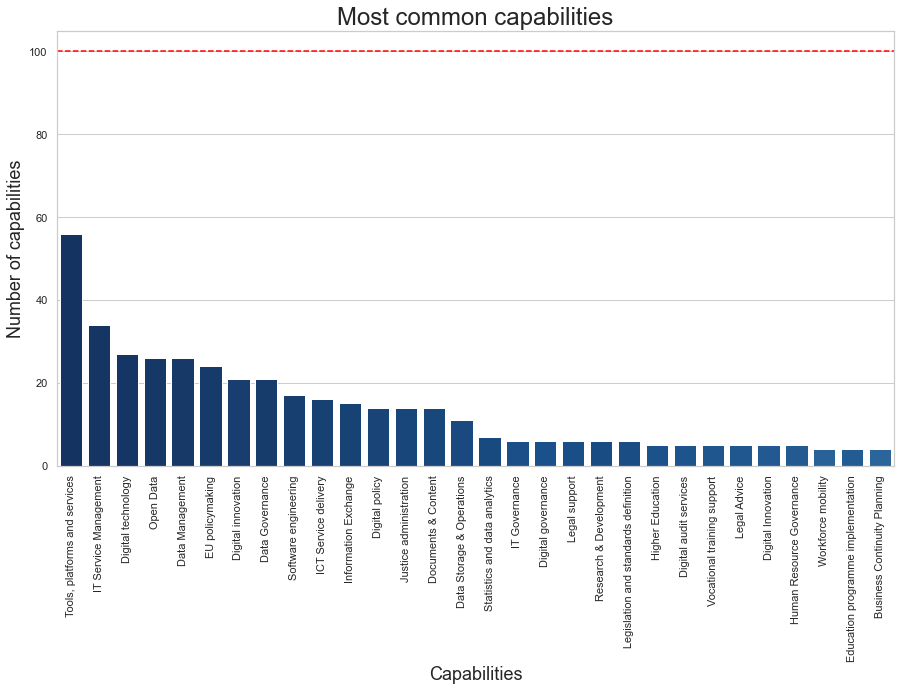

In [250]:
threshold = 100

plt.figure(figsize=(15,8))
sns.set(font_scale = 1)
sns.set_style('whitegrid') 


pal = sns.color_palette("Blues_r", len(most_common_capabilities))
rank = most_common_capabilities['count'].argsort().argsort()  

sns.barplot(most_common_capabilities['Capability'].head(30), most_common_capabilities['count'].head(30), palette=np.array(pal[::-1])[rank])
plt.axhline(threshold, ls='--', c='red')
plt.title("Most common capabilities", fontsize=24)
plt.ylabel('Number of capabilities', fontsize=18)
plt.xlabel('Capabilities', fontsize=18)
plt.xticks(rotation='vertical')

plt.show()

In [251]:
class_weight = {}
for index, label in enumerate(labels):
    class_weight[index] = most_common_capabilities[most_common_capabilities['Capability'] == label]['class_weight'].values[0]

In [252]:
class_weight

{0: 308.0,
 1: 308.0,
 2: 154.0,
 3: 616.0,
 4: 29.333333333333332,
 5: 308.0,
 6: 616.0,
 7: 205.33333333333334,
 8: 56.0,
 9: 308.0,
 10: 616.0,
 11: 616.0,
 12: 29.333333333333332,
 13: 44.0,
 14: 22.814814814814813,
 15: 616.0,
 16: 25.666666666666668,
 17: 154.0,
 18: 616.0,
 19: 616.0,
 20: 616.0,
 21: 308.0,
 22: 123.2,
 23: 38.5,
 24: 616.0,
 25: 616.0,
 26: 123.2,
 27: 102.66666666666667,
 28: 102.66666666666667,
 29: 154.0,
 30: 616.0,
 31: 616.0,
 32: 154.0,
 33: 308.0,
 34: 11.0,
 35: 308.0,
 36: 616.0,
 37: 616.0,
 38: 308.0,
 39: 123.2,
 40: 308.0,
 41: 154.0}

Class weights were tested in the training process in terms of loss due to class imbalancing. Suitable for multi-class, but not for multi-label classification.

### Train Test Split

In [253]:
def train_test_ds_split(texts, labels, test_size=0.3, random_state=111):
    '''
        Split the data into training and testing datasets.
    '''
    
    X = get_features(texts)
    Y = multilabel_binarizer.transform(labels)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    X_file, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, Y_train, Y_test

**Scikit-multilearn** provides an implementation of iterative stratification which aims to provide well-balanced distribution of evidence of label relations up to a given order.

In [28]:
def train_val_split_multilearn(texts, labels, test_size=0.5):
    '''
        Multi-label data stratification - split the data into training and validation datasets using 
        the multilearn approach.
    '''
    X = get_features(texts)
    Y = multilabel_binarizer.transform(labels)
    
    x_train, y_train, x_val, y_val = iterative_train_test_split(X, Y, test_size=test_size)
    return x_train, y_train, x_val, y_val

In [151]:
def train_val_split_multilearn_bert(texts, labels, test_size=0.5):
    '''
        Multi-label data stratification - split the data into training and validation datasets using 
        the multilearn approach. Bert-related!
    '''
    X = tokenize(texts, tokenizer_bert)
    Y = multilabel_binarizer.transform(labels)
    
    x_train_bert, y_train_bert, x_val_bert, y_val_bert = iterative_train_test_split(X[0], Y, test_size=test_size)
    x_train_attention_mask, y_train_bert, x_val_attention_mask, y_val_bert = iterative_train_test_split(X[1], Y, test_size=test_size)
    
    return x_train_bert, x_train_attention_mask, y_train_bert, x_val_bert, x_val_attention_mask, y_val_bert

In [29]:
x_train, y_train, x_val, y_val = train_val_split_multilearn(ds_text['Text'], ds_text['Capabilities'], test_size=0.5)

In [30]:
pd.DataFrame({
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(y_train, order=2) for combination in row),
    'val' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_val, order=2) for combination in row)
}).T.fillna(0.0)

(32, 34)  (16, 32)  (14, 16)  (22, 23)  (22, 32)  (14, 22)  (23, 34)  \
train       7.0       7.0      21.0       7.0       7.0       4.0      28.0   
val         7.0       7.0      21.0       7.0       7.0       3.0      28.0   

       (34, 34)  (14, 34)  (13, 14)  ...  (8, 19)  (19, 19)  (19, 25)  \
train      41.0      32.0      18.0  ...      1.0       1.0       1.0   
val        39.0      31.0      17.0  ...      1.0       1.0       1.0   

       (17, 25)  (17, 31)  (8, 25)  (8, 31)  (41, 41)  (20, 41)  (20, 20)  
train       1.0       1.0      1.0      1.0       1.0       1.0       1.0  
val         1.0       1.0      1.0      1.0       1.0       1.0       1.0  

[2 rows x 165 columns]

Label combination evidence is well balanced between the splits.

Due to the small number of documents included in the dataset, the testing dataset is used for validation purposes, i.e. hyper parameters optimization. A testing dataset will be derived and used at a later stage(TODO).

In [381]:
x_train_bert, x_train_attention_mask, y_train_bert, x_val_bert, x_val_attention_mask, y_val_bert = train_val_split_multilearn_bert(ds_text['Text'], ds_text['Capabilities'], test_size=0.5)

  0%|          | 0/147 [00:00<?, ?it/s]C:\Users\Maria\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2090: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 147/147 [02:49<00:00,  1.15s/it]


In [382]:
assert x_train_bert.shape[0] == x_train_attention_mask.shape[0]

## Building an ANN Model

### Glove Embedding

In [174]:
embeddings_index = {}

f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [175]:
EMBEDDING_DIM = 100

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### Bidirectional LSTM Model  

* Train two instead of one LSTMs on the input sequence
* Improve model performance on sequence classification problems
* Create two copies of the hidden layer, one fit in the input sequences as is and one on a reversed copy of the input sequence. By default, the output values from these LSTMs will be concatenated

In [262]:
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix], mask_zero=True,
                            trainable=True)(input_layer)

decision_layers = SpatialDropout1D(0.2)(embedding_layer)
#with Bidirectional layer, the cell state goes in both directions
decision_layers = Bidirectional(LSTM(MAX_SEQUENCE_LENGTH, dropout=0.2, recurrent_dropout=0.4))(decision_layers)
decision_layers = Dense(1000, activation='tanh')(decision_layers)
decision_layers = Dropout(0.3)(decision_layers)
decision_layers = Dense(42, activation='sigmoid')(decision_layers)#42 corresponds with the number of labels taken into account

capability_model = Model(inputs=input_layer, outputs=decision_layers)

capability_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 300, 100)          1684600   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 300, 100)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 600)               962400    
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              601000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 42)                4204

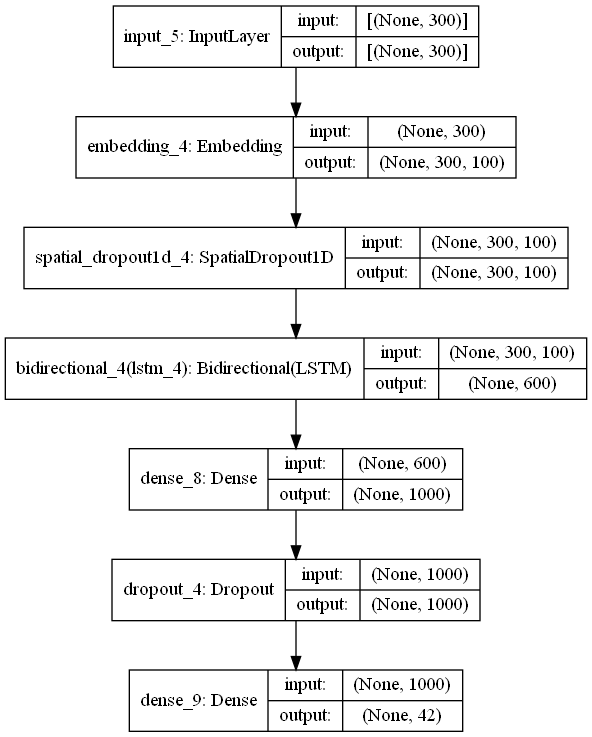

In [263]:
plot_model(capability_model, show_shapes=True)

## Callbacks

In [264]:
model_file_template = "capability_model.{epoch:02d}-loss.{val_loss:.2f}-val_auc.{val_auc:.2f}.hdf5"

In [265]:
checkpointer = ModelCheckpoint(filepath=PATH_MODEL + model_file_template, monitor='val_auc', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_auc', min_delta=0.001, patience=10, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.6, patience=5, verbose=0, mode='max', min_delta=0.001)
tensorboard = TensorBoard(log_dir=TENSORBOARD_LOG, histogram_freq=0, write_graph=False, write_images=True, update_freq="epoch")

callbacks = [checkpointer, early_stopping, reduce_lr, tensorboard]

## Configure the Model

In [271]:
capability_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae', keras.metrics.AUC(
    num_thresholds=3,
    curve="ROC",
    summation_method="majoring",
    name='auc',
    dtype=None,
    thresholds=None,
    multi_label=True,
    label_weights=None)])

## Train the Model

In [273]:
history = capability_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=32,
                                    verbose=True, callbacks=callbacks)

Epoch 1/20
3/3 [==============================] - 33s 10s/step - loss: 0.2054 - mae: 0.1146 - auc: 0.9630 - val_loss: 0.2629 - val_mae: 0.1256 - val_auc: 0.9788
Epoch 2/20
3/3 [==============================] - 31s 10s/step - loss: 0.2048 - mae: 0.1125 - auc: 0.9638 - val_loss: 0.2589 - val_mae: 0.1319 - val_auc: 0.9681
Epoch 3/20
3/3 [==============================] - 32s 10s/step - loss: 0.1919 - mae: 0.1179 - auc: 0.9666 - val_loss: 0.2627 - val_mae: 0.1380 - val_auc: 0.9696
Epoch 4/20
3/3 [==============================] - 33s 10s/step - loss: 0.1908 - mae: 0.1191 - auc: 0.9669 - val_loss: 0.2627 - val_mae: 0.1303 - val_auc: 0.9693
Epoch 5/20
3/3 [==============================] - 33s 10s/step - loss: 0.1817 - mae: 0.1084 - auc: 0.9688 - val_loss: 0.2721 - val_mae: 0.1250 - val_auc: 0.9731
Epoch 6/20
3/3 [==============================] - 33s 10s/step - loss: 0.1708 - mae: 0.1011 - auc: 0.9712 - val_loss: 0.2743 - val_mae: 0.1288 - val_auc: 0.9621
Epoch 7/20
3/3 [==================

In [274]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.style.use('seaborn')
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show

In [276]:
#plot_graphs(history, 'auc')

In [129]:
#plot_graphs(history, 'loss')

### DistilBert Model

In [386]:
def create_bert():
    
    #config = DistilBertConfig(dropout=0.2, attention_dropout=0.2, output_attentions=True)

    
    transformer_model = TFDistilBertModel.from_pretrained(DISTIL_BERT_MODEL)

    input_ids_in = Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_token', dtype='int32')
    input_masks_in = Input(shape=(MAX_SEQUENCE_LENGTH,), name='masked_token', dtype='int32') 

    embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
    X = Bidirectional(LSTM(MAX_SEQUENCE_LENGTH, return_sequences=True))(embedding_layer)
    X = GlobalMaxPool1D()(X)
    X = Dense(600, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(42, activation='sigmoid')(X)
    model = Model(inputs=[input_ids_in, input_masks_in], outputs = X)

    for layer in model.layers[:3]:
        layer.trainable = False

    return model

In [387]:
bert_model = create_bert()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


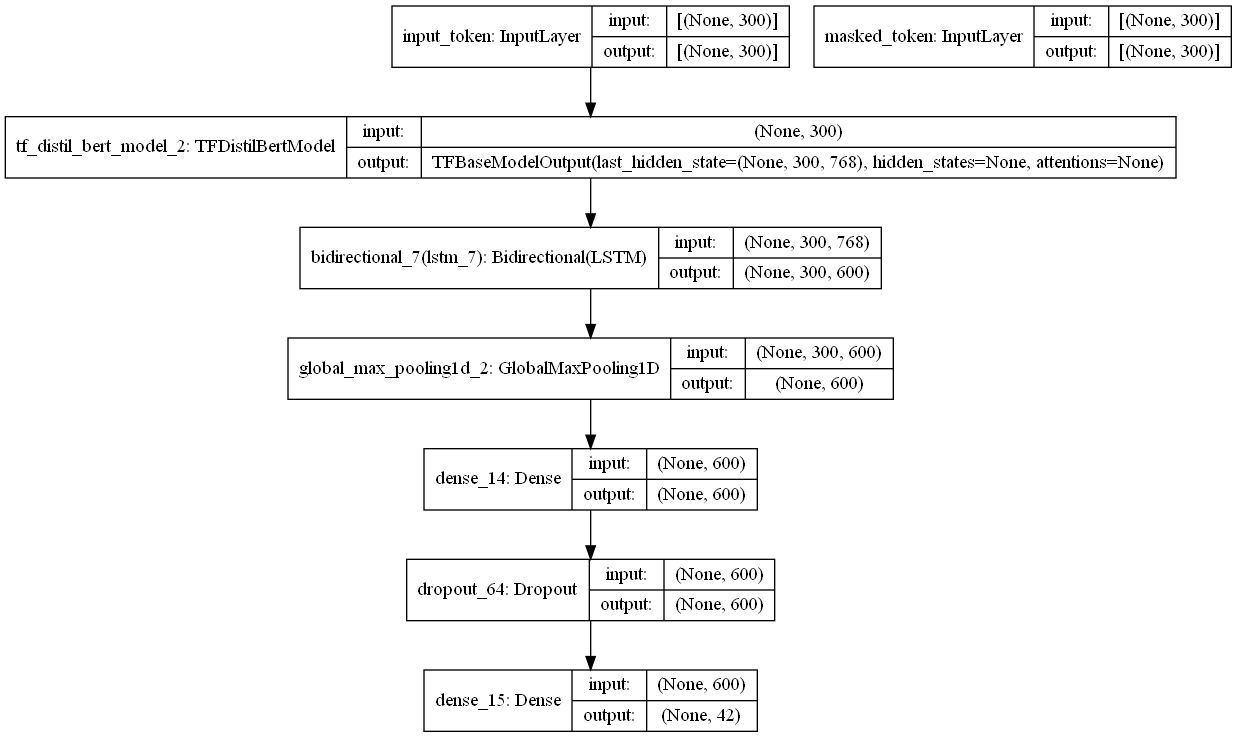

In [388]:
plot_model(bert_model, show_shapes=True)

In [395]:
bert_model_file_template = "bert_model.{epoch:02d}-loss.{val_loss:.2f}-val_auc.{val_auc:.2f}.hdf5"

In [396]:
checkpointer = ModelCheckpoint(filepath=path_model + bert_model_file_template, monitor='val_auc', save_best_only=True, mode='max', save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_auc', min_delta=0.001, patience=10, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.3, patience=5, verbose=0, mode='max', min_delta=0.001)
#tensorboard = TensorBoard(log_dir=TENSORBOARD_LOG, histogram_freq=0, write_graph=False, write_images=True, update_freq="epoch")

callbacks = [checkpointer, early_stopping, reduce_lr]

In [397]:
bert_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae', keras.metrics.AUC(
    num_thresholds=3,
    curve="ROC",
    summation_method="majoring",
    name='auc',
    dtype=None,
    thresholds=None,
    multi_label=True,
    label_weights=None)])

In [ ]:
pd.options.display.float_format = '{:,.0f}'.format

In [398]:
bert_history = bert_model.fit([x_train_bert, x_train_attention_mask], y_train_bert, batch_size=1024,
                              validation_data=([x_val_bert, x_val_attention_mask], y_val_bert),
                              epochs=20, callbacks=callbacks)

Epoch 1/20
1/1 [==============================] - 73s 73s/step - loss: 0.2234 - mae: 0.1198 - auc: 0.9547 - val_loss: 0.2296 - val_mae: 0.1208 - val_auc: 1.0000
Epoch 2/20
1/1 [==============================] - 63s 63s/step - loss: 0.2259 - mae: 0.1222 - auc: 0.9707 - val_loss: 0.2199 - val_mae: 0.1237 - val_auc: 0.9850
Epoch 3/20
1/1 [==============================] - 63s 63s/step - loss: 0.2145 - mae: 0.1248 - auc: 0.9542 - val_loss: 0.2219 - val_mae: 0.1215 - val_auc: 0.9994
Epoch 4/20
1/1 [==============================] - 64s 64s/step - loss: 0.2176 - mae: 0.1240 - auc: 0.9637 - val_loss: 0.2208 - val_mae: 0.1198 - val_auc: 0.9988
Epoch 5/20
1/1 [==============================] - 63s 63s/step - loss: 0.2096 - mae: 0.1179 - auc: 0.9653 - val_loss: 0.2188 - val_mae: 0.1205 - val_auc: 0.9944
Epoch 6/20
1/1 [==============================] - 62s 62s/step - loss: 0.2092 - mae: 0.1193 - auc: 0.9620 - val_loss: 0.2193 - val_mae: 0.1212 - val_auc: 0.9982
Epoch 7/20
1/1 [==================

### Model Predictions

In [22]:
#To avoid prediction representations incl. scientific notations.
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [174]:
#To load the best model so far incl. 42 capabilities.
model = load_model(PATH_BEST_MODELS + 'capability_model_extended.hdf5')

In [175]:
model.get_config()

{'name': 'model_5',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 300),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_5'},
   'name': 'input_5',
   'inbound_nodes': []},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding_4',
    'trainable': True,
    'batch_input_shape': (None, 300),
    'dtype': 'float32',
    'input_dim': 16846,
    'output_dim': 100,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': True,
    'input_length': 300},
   'name': 'embedding_4',
   'inbound_nodes': [[['input_5', 0, 0, {}]]]},
  {'class_name': 'SpatialDropout1D',
   'config': {'name': 'spatial_dropout1d_4',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.2,
    'noise_shape': None,
    'seed': None},
   'name':

In [176]:
predictions = model.predict(x_val)

A validation instead of a testng dataset is used for prediction purposes (just for representation). At this stage, 
a tesing dataset does not exist due to lack of data.

In [37]:
def prediction_to_label(prediction):
    '''
        Returns a dictionary in the following form: {'capability': confidence}, sorted in a descending order.
    '''
    prob = [(labels[i], prob) for i, prob in enumerate(prediction.tolist())]
    return dict(sorted(prob, key=lambda kv: kv[1], reverse=True))

In [38]:
prediction_to_label(predictions[3])

{'Digital policy': 0.9997719526290894,
 'EU policymaking': 0.9993256330490112,
 'Tools, platforms and services': 0.9960516691207886,
 'ICT Service delivery': 0.9950965642929077,
 'Security control': 0.9928948879241943,
 'Human Resource Governance': 0.9918358325958252,
 'Digital technology': 0.006456196308135986,
 'Legislation and standards definition': 0.003090202808380127,
 'Digital Strategy': 0.0010783076286315918,
 'Digital Services ': 0.0010490715503692627,
 'Data Governance': 0.0004030764102935791,
 'HR mobile strategy': 0.0002709329128265381,
 'Legal Advice': 0.00020772218704223633,
 'Workforce mobility': 0.000202864408493042,
 'Legal support': 0.00020119547843933105,
 'Administrative Law': 0.0001812577247619629,
 'Business Intelligence': 0.00017139315605163574,
 'Policy definition coordination': 0.0001652240753173828,
 'Data Quality': 0.000148773193359375,
 'Data management': 0.00012242092634551227,
 'Inter-institutional information exchange': 9.635375317884609e-05,
 'Education,

### TODO

* Include more documents in the dataset
* Ergo, more capabilities
* Take into account a testing dataset
* Stipulate the way for adding capabilities emergingly